# Synthetic Data generation using Variational Autoencoders.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import layers, models, losses
from tensorflow.keras.optimizers import Adam
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Setting up the eager mode in tensorflow
tf.config.run_functions_eagerly(True)

Loading the Data from google drive : card_transaction.v1.csv

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
%cd /content/drive/My Drive/Fraud Analytics Datasets/SDG_VAE

file_name = 'card_transaction.v1.csv'
data = pd.read_csv(file_name)

print("First 10 row of data set")
print(data.head(11))

/content/drive/My Drive/Fraud Analytics Datasets/SDG_VAE
First 10 row of data set
    User  Card  Year  Month  Day   Time   Amount           Use Chip  \
0      0     0  2002      9    1  06:21  $134.09  Swipe Transaction   
1      0     0  2002      9    1  06:42   $38.48  Swipe Transaction   
2      0     0  2002      9    2  06:22  $120.34  Swipe Transaction   
3      0     0  2002      9    2  17:45  $128.95  Swipe Transaction   
4      0     0  2002      9    3  06:23  $104.71  Swipe Transaction   
5      0     0  2002      9    3  13:53   $86.19  Swipe Transaction   
6      0     0  2002      9    4  05:51   $93.84  Swipe Transaction   
7      0     0  2002      9    4  06:09  $123.50  Swipe Transaction   
8      0     0  2002      9    5  06:14   $61.72  Swipe Transaction   
9      0     0  2002      9    5  09:35   $57.10  Swipe Transaction   
10     0     0  2002      9    5  20:18   $76.07  Swipe Transaction   

    Merchant Name  Merchant City Merchant State      Zip     MCC 

Removing dollar and Printing the target values

In [5]:
data['Amount'] = data['Amount'].replace('[\$]','', regex=True).astype(float)
print(data['Amount'].head(11))

0     134.09
1      38.48
2     120.34
3     128.95
4     104.71
5      86.19
6      93.84
7     123.50
8      61.72
9      57.10
10     76.07
Name: Amount, dtype: float64


Encoding the columns into numerical values and printing them

In [6]:
columnLabelEncoders = {}
# columnsToRemove = {'Amount','User','Card','Year','Month','Day','Merchant Name','Zip','MCC'}
columnsToRemove = {'Amount'}
for column in data.select_dtypes(include='object').columns:
    if column not in columnsToRemove:
      columnLabelEncoders[column] = LabelEncoder()
      data[column] = columnLabelEncoders[column].fit_transform(data[column])

# Printing the features after encoding them into numerical values.
print(data.head(10))

   User  Card  Year  Month  Day  Time  Amount  Use Chip  Merchant Name  \
0     0     0  2002      9    1   381  134.09         2   3.527213e+18   
1     0     0  2002      9    1   402   38.48         2  -7.276121e+17   
2     0     0  2002      9    2   382  120.34         2  -7.276121e+17   
3     0     0  2002      9    2  1066  128.95         2   3.414527e+18   
4     0     0  2002      9    3   383  104.71         2   5.817218e+18   
5     0     0  2002      9    3   834   86.19         2  -7.146671e+18   
6     0     0  2002      9    4   351   93.84         2  -7.276121e+17   
7     0     0  2002      9    4   369  123.50         2  -7.276121e+17   
8     0     0  2002      9    5   374   61.72         2  -7.276121e+17   
9     0     0  2002      9    5   575   57.10         2   4.055257e+18   

   Merchant City  Merchant State      Zip     MCC  Errors?  Is Fraud?  
0           3696              16  91750.0  5300.0       20          0  
1           4600              16  91754.0

Now Replacing Nan values with mean of the data

In [7]:
data = data.fillna(data.mean())

Now scaling the data between 0 and 1.

In [9]:
scaler = MinMaxScaler()
num_cols = data.select_dtypes(include=['float64','int64']).columns

data_num_cols = data[num_cols]

scaler.fit(data_num_cols)

data[num_cols] = scaler.transform(data)

# Printing features after scaling
print("Data After scaling")
print(data.head(11))

Data After scaling
    User  Card  Year     Month       Day      Time    Amount  Use Chip  \
0    0.0   0.0  0.28  0.727273  0.000000  0.264583  0.086622  0.666667   
1    0.0   0.0  0.28  0.727273  0.000000  0.279167  0.073561  0.666667   
2    0.0   0.0  0.28  0.727273  0.033333  0.265278  0.084744  0.666667   
3    0.0   0.0  0.28  0.727273  0.033333  0.740278  0.085920  0.666667   
4    0.0   0.0  0.28  0.727273  0.066667  0.265972  0.082608  0.666667   
5    0.0   0.0  0.28  0.727273  0.066667  0.579167  0.080078  0.666667   
6    0.0   0.0  0.28  0.727273  0.100000  0.243750  0.081123  0.666667   
7    0.0   0.0  0.28  0.727273  0.100000  0.256250  0.085175  0.666667   
8    0.0   0.0  0.28  0.727273  0.133333  0.259722  0.076736  0.666667   
9    0.0   0.0  0.28  0.727273  0.133333  0.399306  0.076104  0.666667   
10   0.0   0.0  0.28  0.727273  0.133333  0.846528  0.078696  0.666667   

    Merchant Name  Merchant City  Merchant State       Zip       MCC  Errors?  \
0        0.

Now checking whether any null or infinite values are present or not

In [10]:
if data.isnull().values.any() or np.isinf(data.values).any():
    raise ValueError("Data contains NaN or infinite values")

Defining the variational autoencoder class

In [11]:
class VariationalAutoEncoder(models.Model):
    def __init__(this,originalDimension,latentDimension):
        super(VariationalAutoEncoder,this).__init__()

        this.latentDimension = latentDimension

        # Defining the encoder
        this.encoder = models.Sequential([
            layers.Dense(originalDimension, activation='relu'),
            layers.Dense(12, activation='relu'),
            layers.Dense(10, activation='relu'),
            layers.Dense(2 * latentDimension)
        ])

        # Defining the decoder
        this.decoder = models.Sequential([
            layers.Dense(2 * latentDimension),
            layers.Dense(10, activation='relu'),
            layers.Dense(12, activation='relu'),
            layers.Dense(originalDimension,activation='sigmoid')
        ])

    # Function for encoding data
    def encodeData(this,x):
        meanLogVariance = this.encoder(x)
        mean = meanLogVariance[:, :this.latentDimension]
        logVariance = meanLogVariance[:, this.latentDimension:]
        eps = tf.random.normal(shape=(mean.shape[0], this.latentDimension))
        standardDeviation = tf.exp(0.5 * logVariance)
        z = mean + eps * standardDeviation
        return this.decoder(z)

    # Function for reparameterize data
    def reparameterization(this, mean, logVariance):
        eps = tf.random.normal(shape=(mean.shape[0], this.latentDimension))
        standardDeviation = tf.exp(0.5 * logVariance)
        z = mean + eps * standardDeviation

        return z

    # Abstract function for encoding the data
    def decodeData(this,z):
        return this.decoder(z)

    # kind of Main function
    def call(this, inputs):
        reconstruct = this.encodeData(inputs)

        return reconstruct




Defining the Loss calulaing function for retraining

In [12]:
# Function for calculating the loss, it is used during back propagation
# For re-adjusting the parameters
def LossCalculatorVAE(originalData, reconstruction, mean, logVariance):
    reconstructionLoss = losses.binary_crossentropy(originalData, reconstruction)
    reconstructionLoss = tf.reduce_mean(reconstructionLoss)

    KL_divergence = -0.5 * tf.reduce_mean(1 + logVariance - tf.square(mean) - tf.exp(logVariance))

    return reconstructionLoss + KL_divergence

Activating GPU

In [13]:
print("GPU available:", tf.test.is_gpu_available())
print("TensorFlow is using GPU:", tf.test.is_built_with_cuda())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU available: True
TensorFlow is using GPU: True


Now code for compiling the model

In [14]:
originalDimension = data.shape[1]
latentDimension = 4
optimizer = Adam(learning_rate=0.001)
VAE_model = VariationalAutoEncoder(originalDimension=originalDimension,latentDimension=latentDimension)



**Now Training the VAE model**

In [15]:
# Train the VAE model
VAE_model.compile(optimizer='adam',loss='mse')

VAE_model.fit(data, data,epochs=15, batch_size=500)


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5111/5111 [==============================] - 373s 72ms/step - loss: 0.0309
Epoch 2/15
5111/5111 [==============================] - 343s 67ms/step - loss: 0.0231
Epoch 3/15
5111/5111 [==============================] - 339s 66ms/step - loss: 0.0221
Epoch 4/15
5111/5111 [==============================] - 339s 66ms/step - loss: 0.0211
Epoch 5/15
5111/5111 [==============================] - 401s 78ms/step - loss: 0.0198
Epoch 6/15
5111/5111 [==============================] - 345s 68ms/step - loss: 0.0189
Epoch 7/15
5111/5111 [==============================] - 346s 68ms/step - loss: 0.0183
Epoch 8/15
5111/5111 [==============================] - 348s 68ms/step - loss: 0.0181
Epoch 9/15
5111/5111 [==============================] - 354s 69ms/step - loss: 0.0180
Epoch 10/15
5111/5111 [==============================] - 346s 68ms/step - loss: 0.0179
Epoch 11/15
5111/5111 [==============================] - 340s 66ms/step - loss: 0.0179
Epoch 12/15
5111/5111 [==============================] - 338s 6

Function for Decoding the Data

Now saving the model

In [16]:
from tensorflow.keras.models import save_model, Sequential

# Saving the weights of the model
VAE_model.save_weights("SDG_VAE_MODEL_weights.h5")


Now generating Synthetic data

In [17]:
num_samples = 2000000

# Sample latent vectors from a Gaussian distribution
latent_dim = 4
latent_samples = np.random.normal(size=(num_samples, latent_dim))

# Using the decoder part of the VAE model to generate synthetic data
synthetic_data = VAE_model.decoder.predict(latent_samples)


62500/62500 [==============================] - 270s 4ms/step


Plotting Distribution

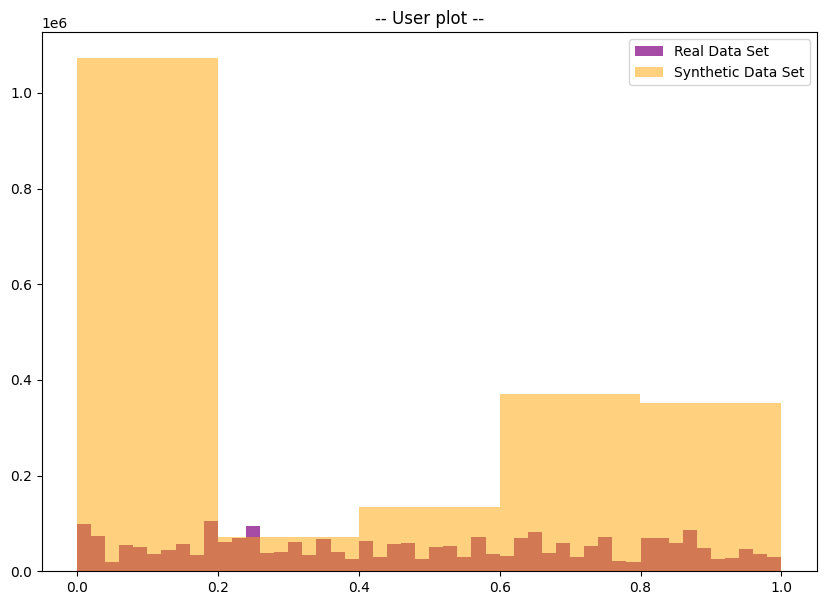

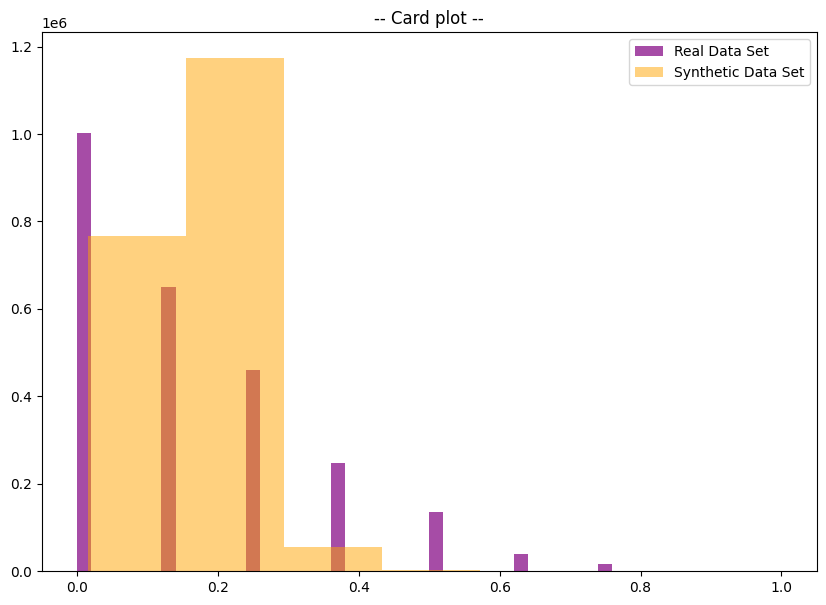

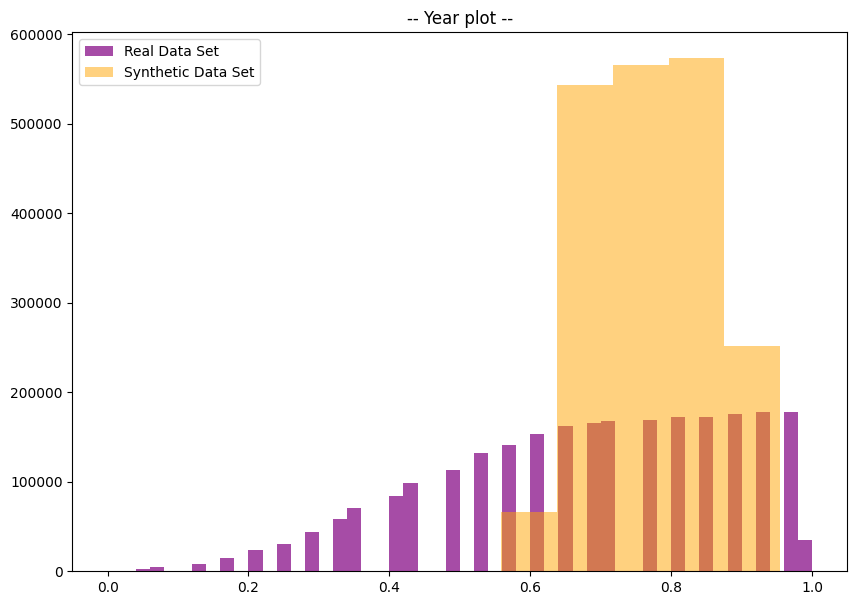

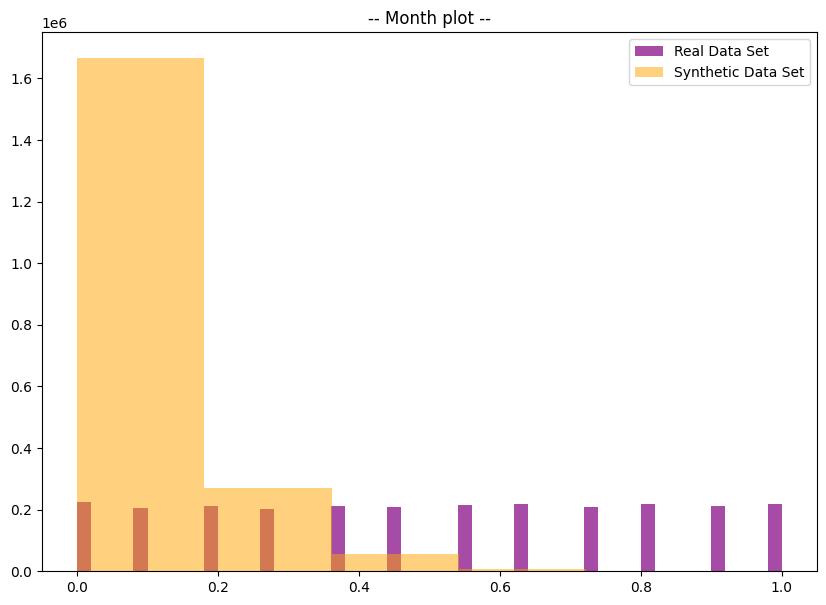

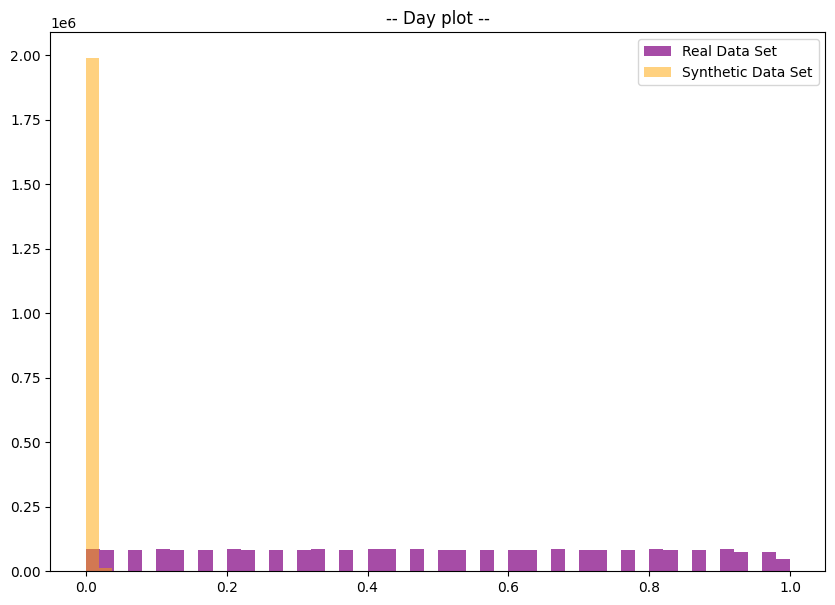

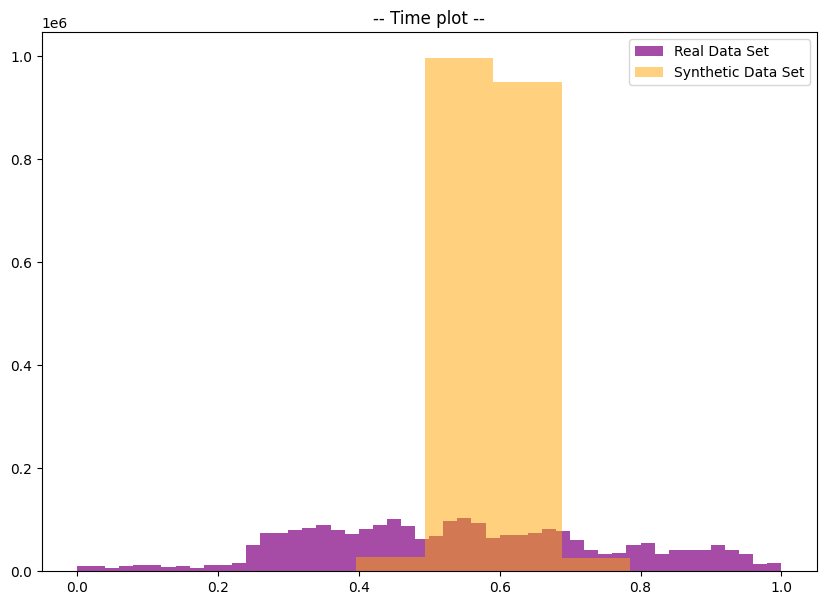

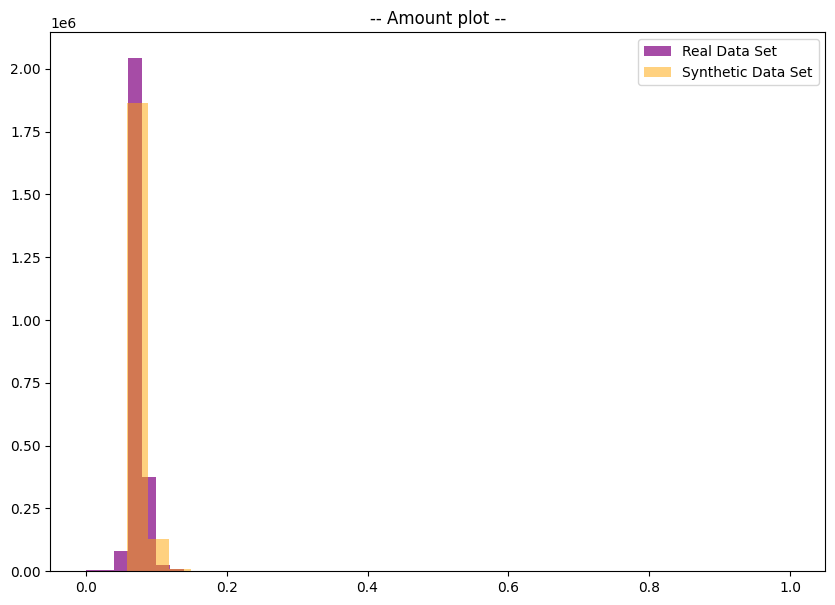

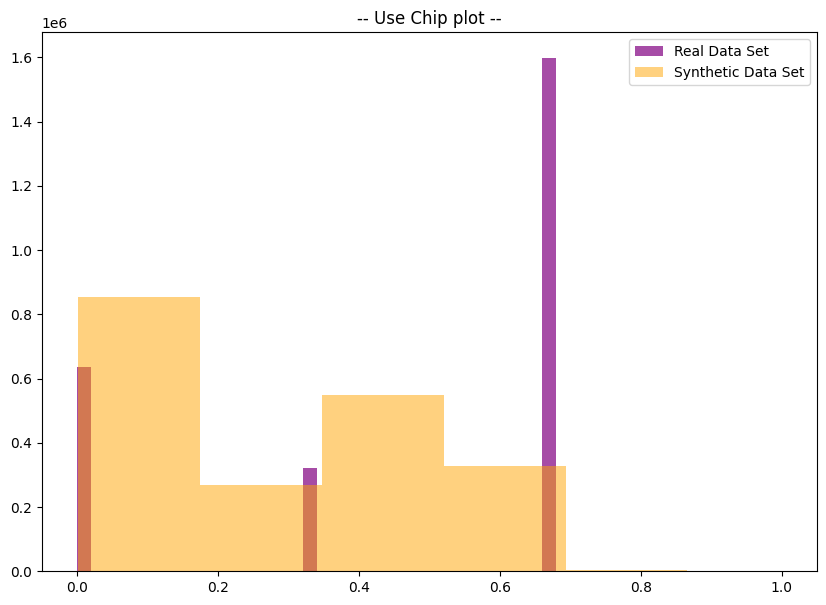

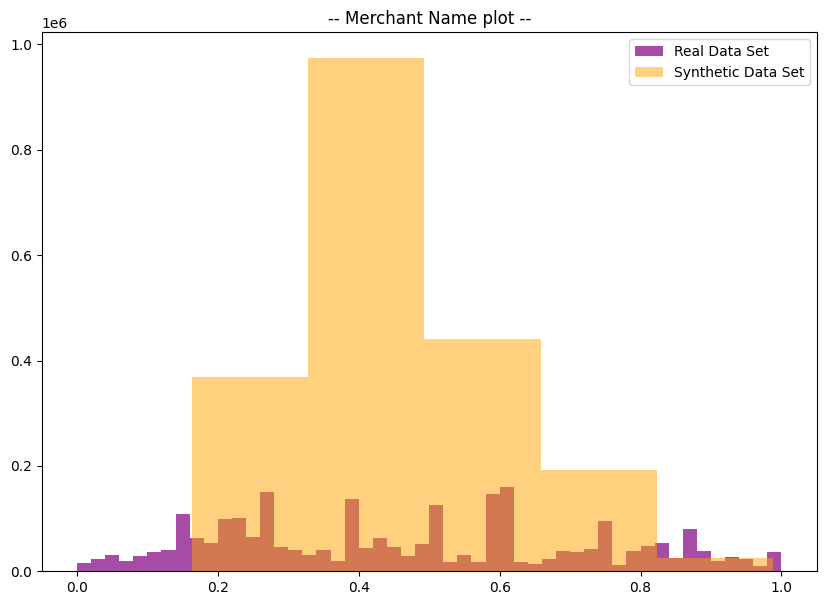

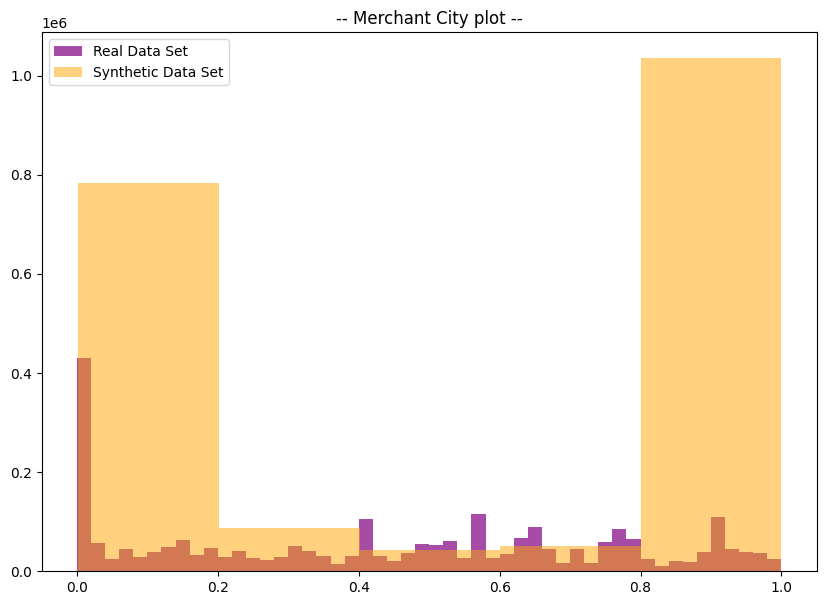

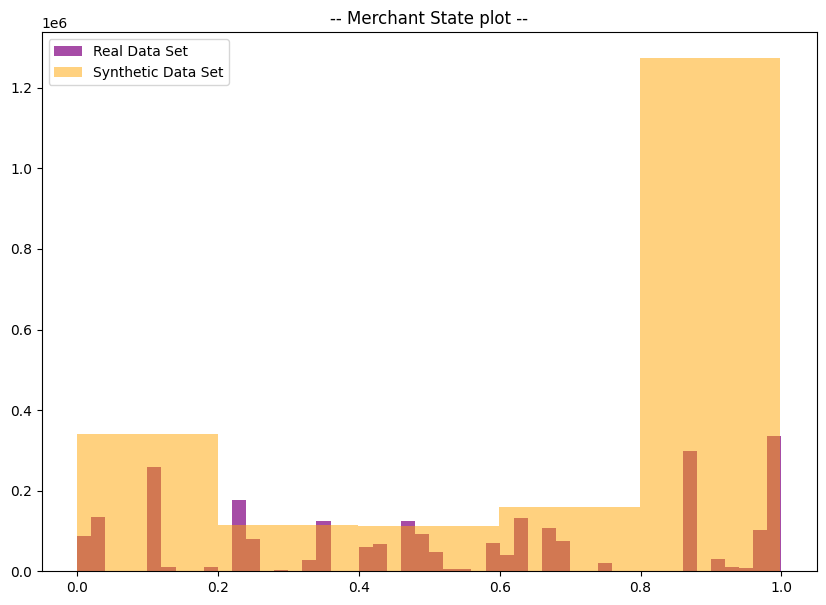

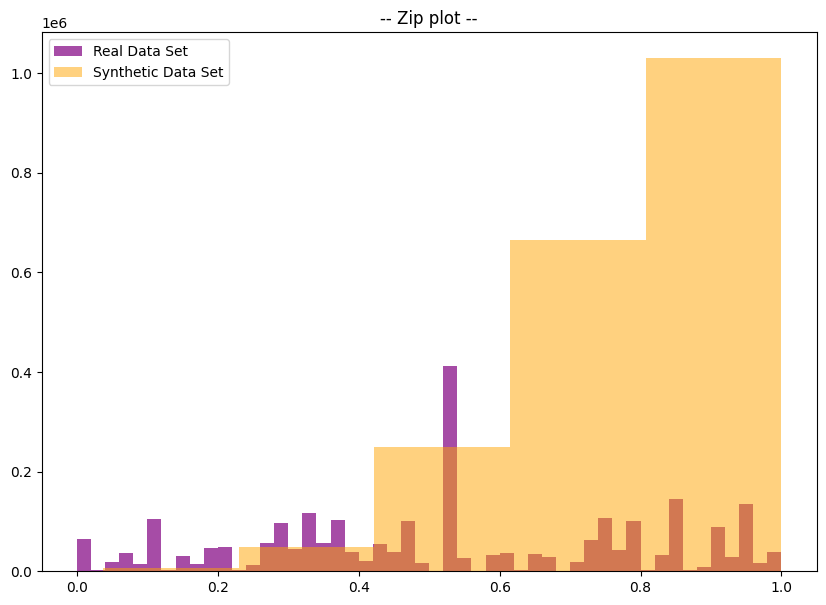

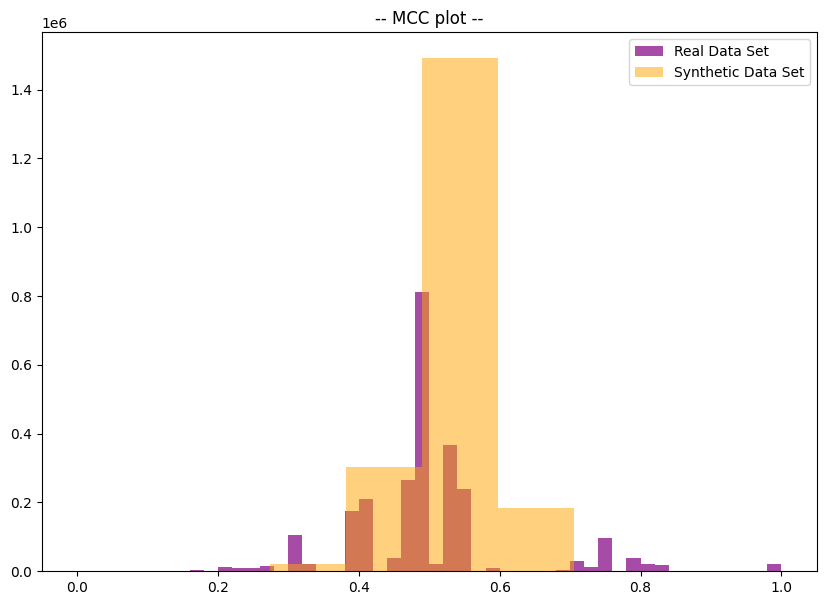

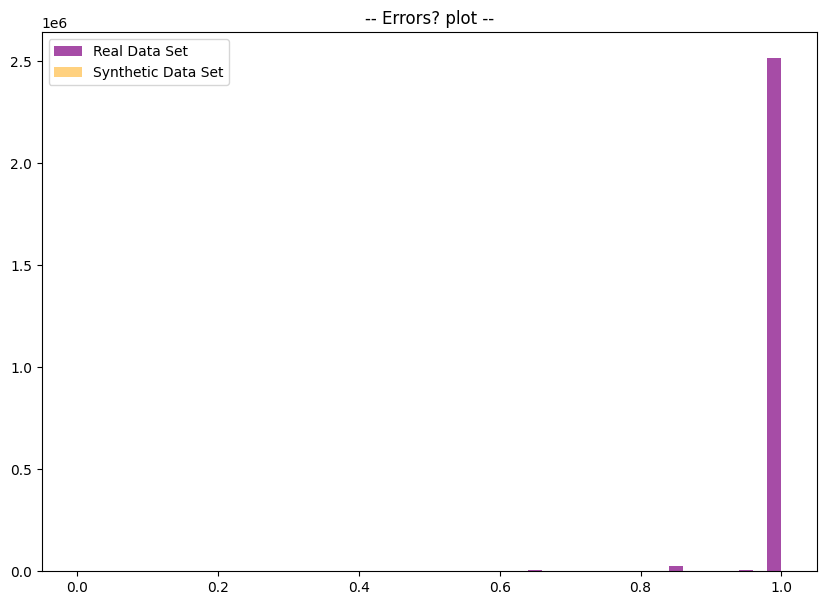

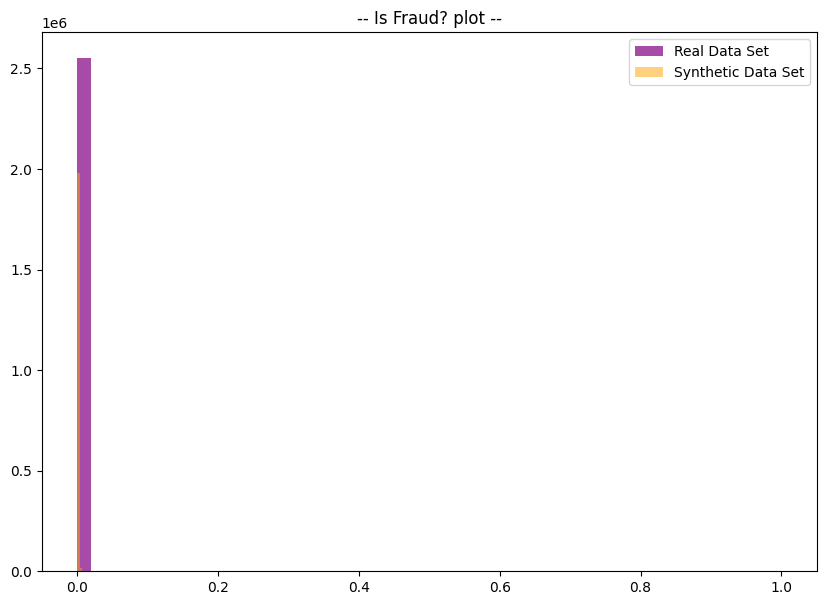

In [28]:
name = "plot_"
for col in data.columns:
    plt.figure(figsize=(10, 7))
    plt.hist(data[col], bins=50, alpha=0.7, color='purple', label='Real Data Set')
    plt.hist(synthetic_data[:, data.columns.get_loc(col)], bins=5, alpha=0.5, color='orange', label='Synthetic Data Set')
    plt.title(f'-- {col} plot --')
    plt.legend()
    saveName = name + str(col)
    plt.savefig(saveName)
    plt.show()


Calculating the metrices

In [23]:
from scipy.stats import ks_2samp, entropy

metrics = {}
for i, col in enumerate(data.columns):
  # Calculate KS statistic
  ks_statistic, ks_p_value = ks_2samp(data[col], synthetic_data[:, i])
  metrics[f"{col}_ks_statistic"] = ks_statistic
  metrics[f"{col}_ks_p_value"] = ks_p_value

# Calculate KL divergence
num_samples_to_compare = min(len(data), len(synthetic_data))
for i, col in enumerate(data.columns):
  kl_divergence = entropy(data[col][:num_samples_to_compare], synthetic_data[:num_samples_to_compare, i])
  metrics[f"{col}_kl_divergence"] = kl_divergence

Plotting metrices

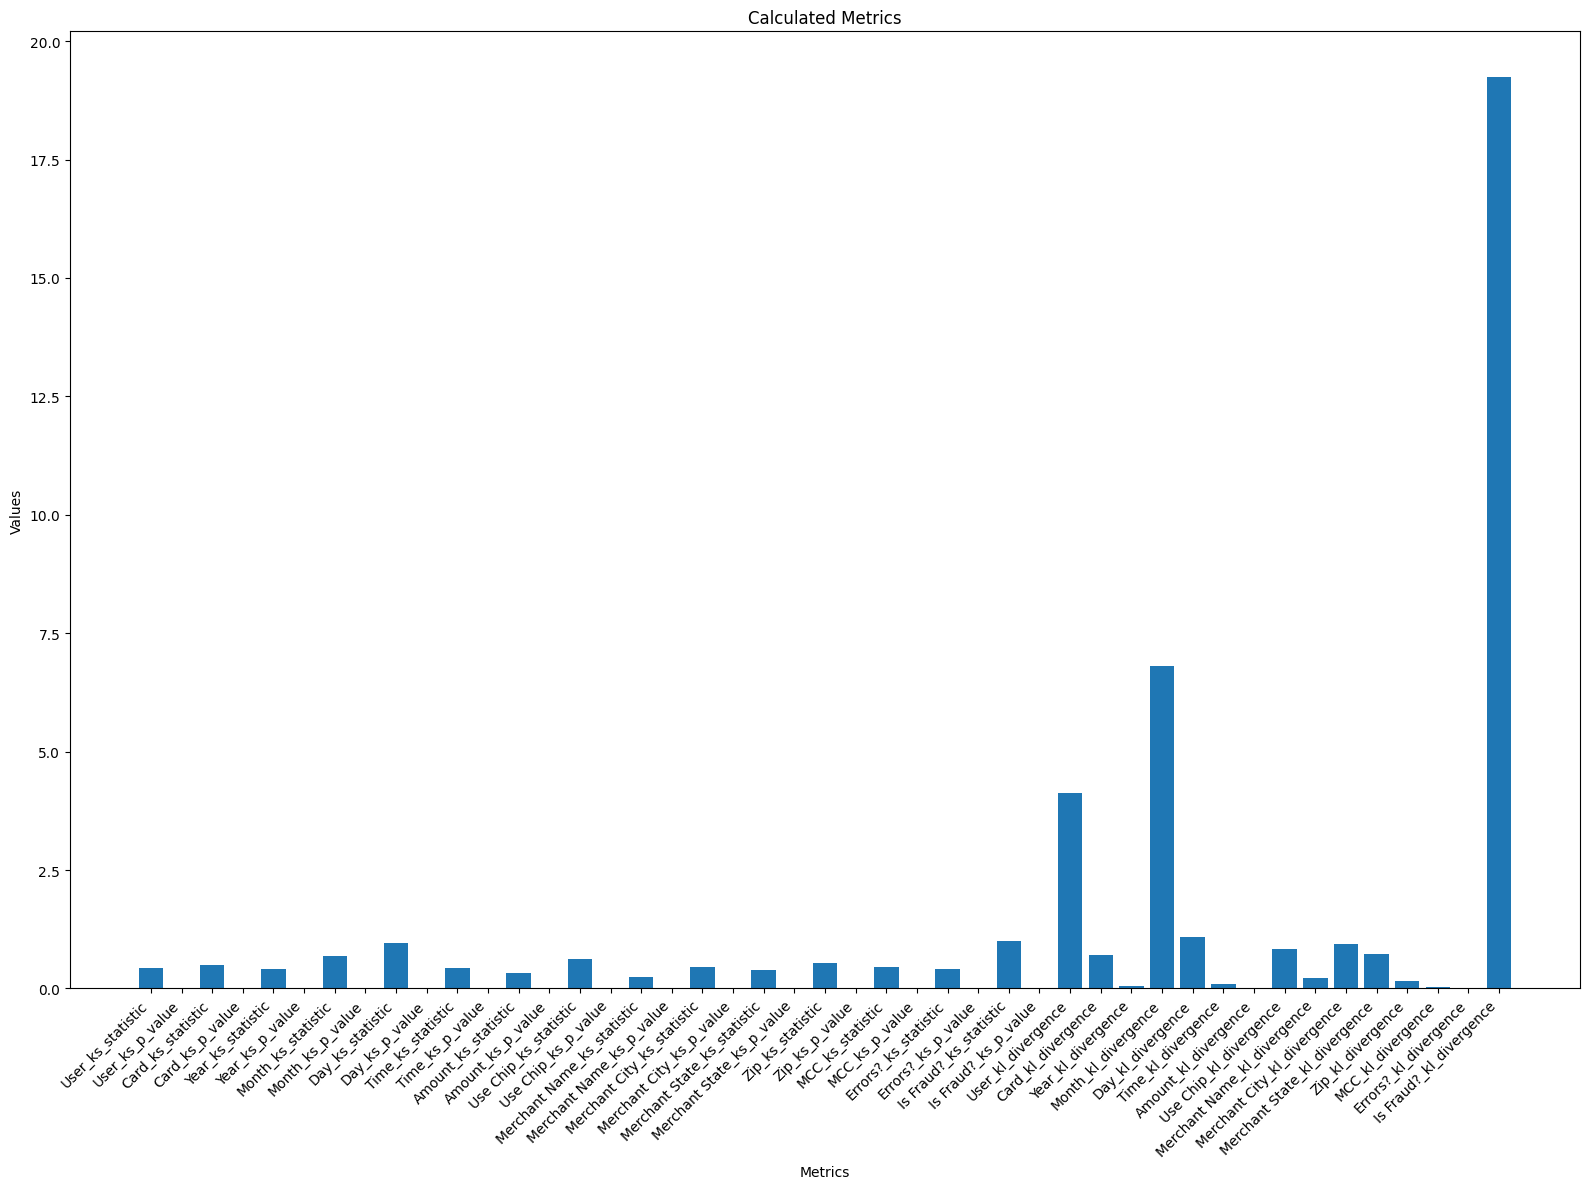

In [27]:
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Create a bar plot
plt.figure(figsize=(16, 12))
plt.bar(metric_names, metric_values)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Calculated Metrics')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.savefig('metrics.png')
plt.show()

Summary:

Synthetic Data generation:

Importing Data:
We used pandas for reading the card transaction csv file

Pre-processing data:

1. We removed the dollar sign from the amount column to make it into a numeric value
2. We then used Label Encoder to encode all the columns except Amount col.
3. Then we fill all the NaN values with the mean of the data using the data.fillna(data.mean()).
4. Then we use Min Max scaler to scale all the values and for that
5. We first select all the columns which have numeric value(either float or int) 
6. Then we do scaler.fit on those data columns
7. Then for each data columns we do scaler.transform
8. Then we will check whether there is a null or infinite value or not in the data set and if there is then we raise a value error.

Defining the Variational Autoencoder

1. Encoder:
1.a We first add a layer which is of original dimension(15) with activation as relu
1.b Then we add another layer with 12 neurons and activation as relu
1.c Then we add another layer with 10 neurons and activation as relu
1.d Then we add final layer whose dimension is 2 * latent dimension

2. Decoder:
2.a We first add a layer  whose dimension is 2 * latent dimension
2.b Then we add another layer with 10 neurons and activation as relu
2.c Then we add another layer with 12 neurons and activation as relu
2.d Then we add final layer of original dimension with activation as sigmoid

3. Then we made a encoder function(encodeData()) who uses the encoder
3.a First we get the mean log variance using the encoder method
3.b Then we separate mean and log variance
3.c Then we calculate an epsilon(of size latent dimension)
3.d Then we calculate the standard deviation and a value z:
3.e z = mean + eps * standard_deviation
3.f Then we pass this z into the decoder method

4. Reparameterization:
4.a We again calculate an epsilon in the same way as above
4.b Then we find standard deviation : tf.exp(0.5* log_variance)
4.c Then we calculate z = mean + eps * standard_deviation
4.d Then we will return this value z

5. Call method:
We will give input to the encoder and get a result and return the result.

6. Loss calculation function:
6.a We take the input as 
6.a.1 Original Data
6.a.2 Reconstructed data
6.a.3 Mean
6.a.4 Log variance

6.b Then we calculate the reconstruction loss as binary cross entropy.
6.c Then we calculate the KL divergence as
KL_divergence = -0.5 * tf.reduce_mean(1+log_variance-tf.square(mean)-tf.exp(log_variance)

6.d Then we return reconstruction_loss + KL_divergence

7. Compiling & training the model
We put the latent dimension = 4 & using Adam optimizer
Then we used the .fit method for training the model.

8. Generating the Synthetic Data
We generated 2 Million samples.


9. Plotting the distributions : We plotted our distribution as real data vs synthetic data.

10. Calculating the metrics:
We calculated the KL Divergence
